In [3]:
from dotenv import load_dotenv
from typing import TypedDict, Literal
from pydantic import BaseModel, Field 
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI


In [4]:
load_dotenv()

True

In [5]:
model = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash-lite"
)

In [6]:
class SentimentSchema(BaseModel):

    sentiment: Literal["positive", "negative"] = Field(description= "sentiment of the review")

In [7]:
structured_model = model.with_structured_output(SentimentSchema)

In [8]:
structured_model.invoke("The match was pretty bad")

SentimentSchema(sentiment='negative')

In [28]:
class ReviewState(TypedDict):

    review:str 
    sentiment: Literal["positive", "negative"]
    diagnosis: dict 
    response:str

In [29]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')
structured_model2 = model.with_structured_output(DiagnosisSchema)


In [33]:
def find_sentiment(state:ReviewState):

    prompt = f"For the following review find out the sentiment \n {state['review']}"

    return {"sentiment":
             structured_model.invoke(prompt).sentiment}


def positive_response(state: ReviewState):
    prompt = f"Write a warm thankyou message in response to this review: \n {state['review']}. \n \
        Also, kindly ask the user to leave the feedback on our website"
    
    return {"response":
            model.invoke(prompt).content}


def run_diagnosis(state: ReviewState):

    prompt = f"Diagnose this negative review: \n {state['review']} \n return issue_type, tone, and urgency"

    response = structured_model2.invoke(prompt)

    return {'diagnosis':
            response.model_dump()}


def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {"response":
            response}


def check_condition(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'


In [34]:
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)

graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_condition)

graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("positive_response", END)
graph.add_edge("negative_response" , END)

workflow = graph.compile()

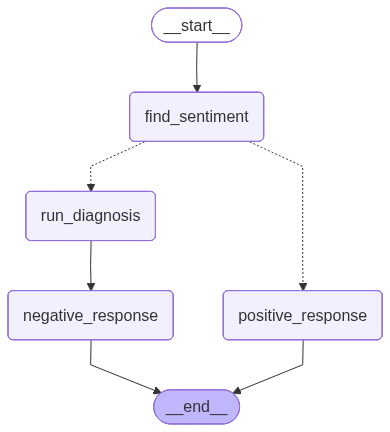

In [35]:
workflow

In [36]:
test_1 = {"review": "I absolutely love this product! It arrived two days early and works exactly as described. The packaging was also very eco-friendly. Great job!"}

workflow.invoke(test_1)

{'review': 'I absolutely love this product! It arrived two days early and works exactly as described. The packaging was also very eco-friendly. Great job!',
 'sentiment': 'positive',
 'response': 'Here are a few options for a warm thank you message, choose the one that best fits your brand\'s voice!\n\n**Option 1 (Concise & Sweet):**\n\n> Wow, thank you so much for your incredibly kind review! We\'re absolutely thrilled to hear you love the product and that it arrived even sooner than expected. It means the world to us that you appreciate our eco-friendly packaging too!\n>\n> We\'d be so grateful if you could share your wonderful experience on our website as well. Your feedback helps us immensely! 😊\n\n**Option 2 (Slightly More Detailed & Enthusiastic):**\n\n> We are absolutely beaming with joy after reading your fantastic review! Thank you from the bottom of our hearts for taking the time to share your experience. Knowing that the product arrived early and works perfectly for you is e

In [37]:
test_2 = {"review": "The app keeps crashing every time I try to upload a photo. This is a critical bug for my business and I need it fixed immediately. Very frustrated!"}
workflow.invoke(test_2)

{'review': 'The app keeps crashing every time I try to upload a photo. This is a critical bug for my business and I need it fixed immediately. Very frustrated!',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': 'I\'m so sorry to hear you\'re experiencing a bug and that it\'s causing you frustration. I understand how disruptive and upsetting that can be, especially with high urgency.\n\nPlease know that we\'re taking this very seriously and are committed to getting this resolved for you as quickly as possible.\n\nTo help us pinpoint the issue and find the best solution, could you please provide a bit more detail about the bug you\'re encountering? For example:\n\n*   **What specifically is happening?** (e.g., "The save button isn\'t working," "I\'m seeing an error message," "The application is crashing.")\n*   **When did this start happening?**\n*   **Are there any specific steps you take that trigger the bug?**\n*   **